<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/Engulfing_Candles_Hisse_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

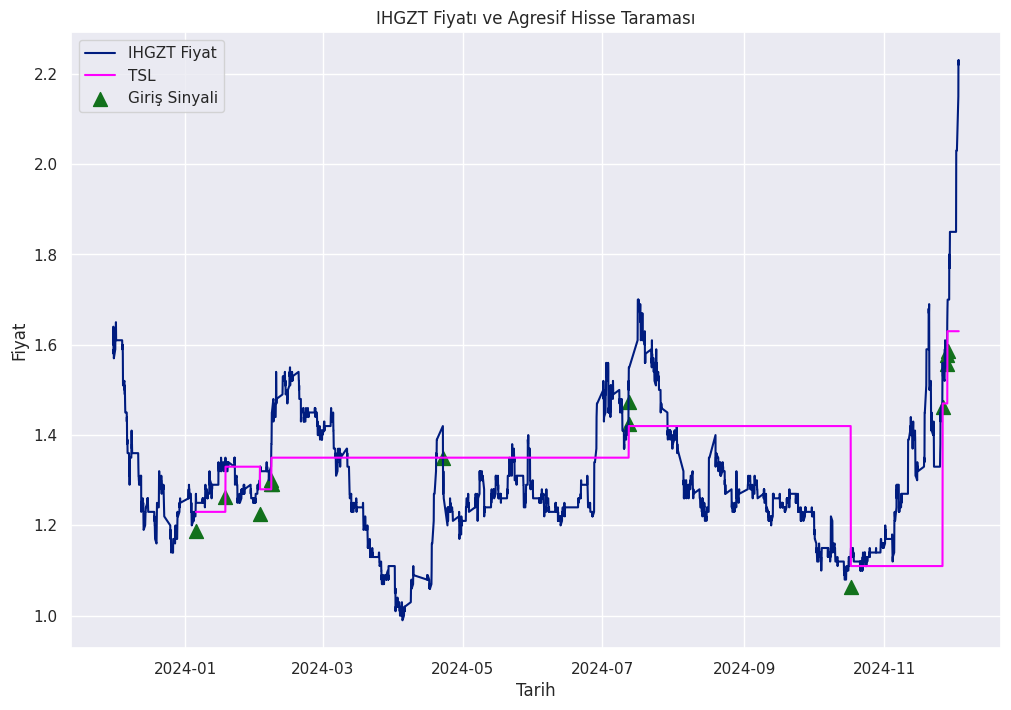

IHGZT için Bullish Engulfing Pattern Sinyal Tarihleri:
2024-01-05 14:00:00+03:00
2024-01-18 11:00:00+03:00
2024-02-02 13:00:00+03:00
2024-02-07 12:00:00+03:00
2024-02-07 13:00:00+03:00
2024-02-07 14:00:00+03:00
2024-04-22 09:00:00+03:00
2024-07-12 12:00:00+03:00
2024-07-12 13:00:00+03:00
2024-10-17 10:00:00+03:00
2024-11-26 12:00:00+03:00
2024-11-28 14:00:00+03:00
2024-11-28 15:00:00+03:00
2024-11-28 16:00:00+03:00


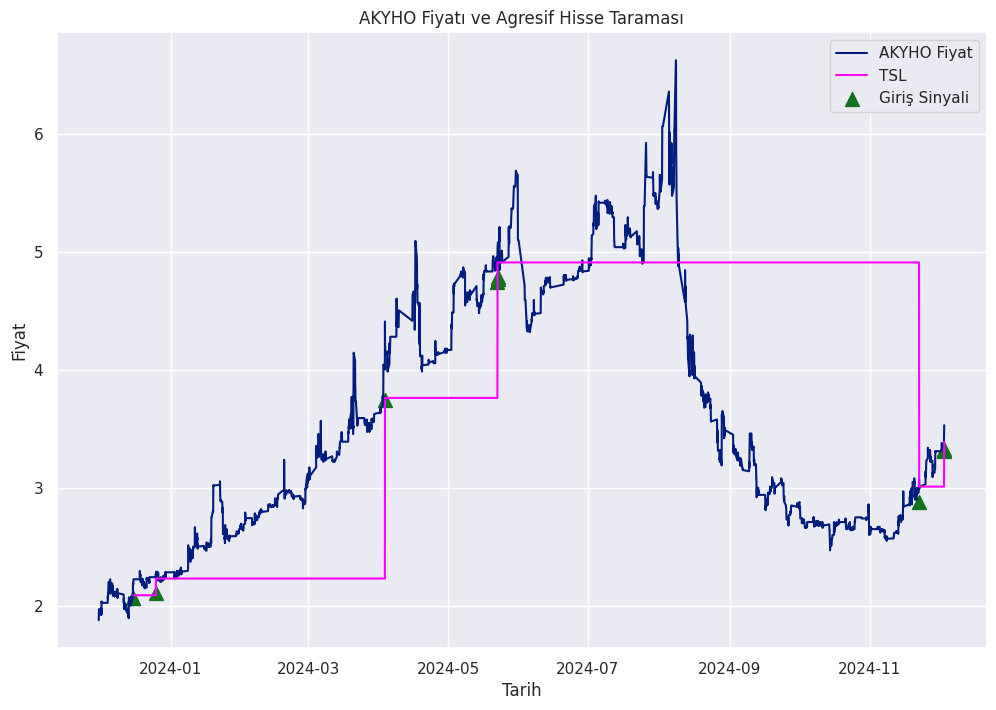

AKYHO için Bullish Engulfing Pattern Sinyal Tarihleri:
2023-12-15 12:00:00+03:00
2023-12-15 13:00:00+03:00
2023-12-25 10:00:00+03:00
2024-04-03 10:00:00+03:00
2024-05-22 13:00:00+03:00
2024-05-22 14:00:00+03:00
2024-05-22 15:00:00+03:00
2024-11-22 14:00:00+03:00
2024-12-03 12:00:00+03:00
2024-12-03 13:00:00+03:00


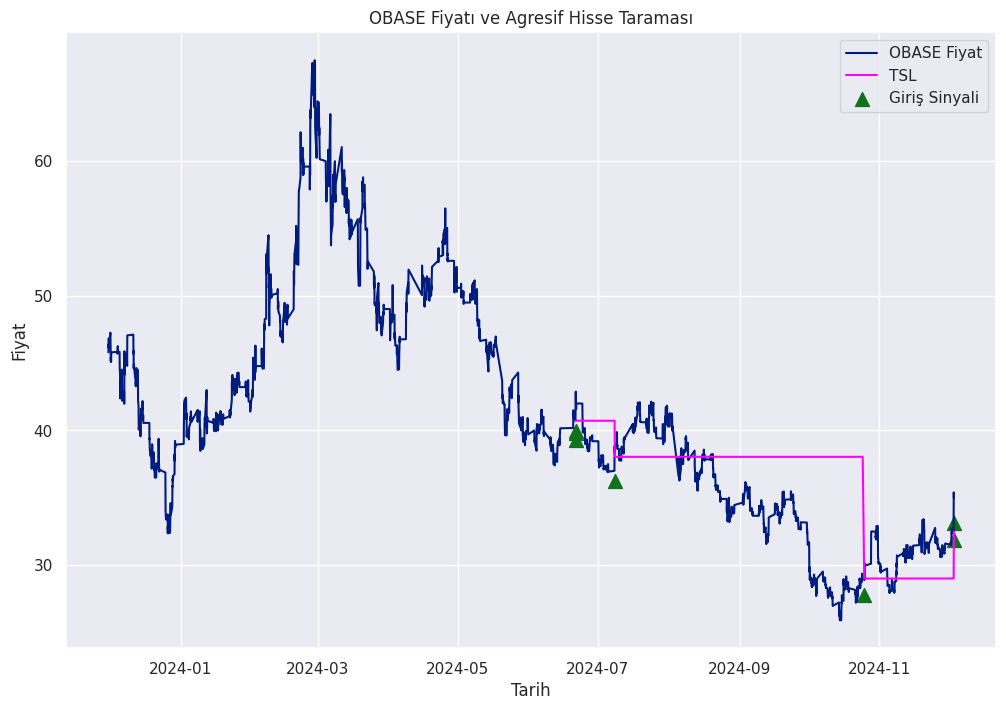

OBASE için Bullish Engulfing Pattern Sinyal Tarihleri:
2024-06-21 11:00:00+03:00
2024-06-21 12:00:00+03:00
2024-06-21 13:00:00+03:00
2024-07-08 12:00:00+03:00
2024-10-25 09:00:00+03:00
2024-12-03 12:00:00+03:00
2024-12-03 13:00:00+03:00


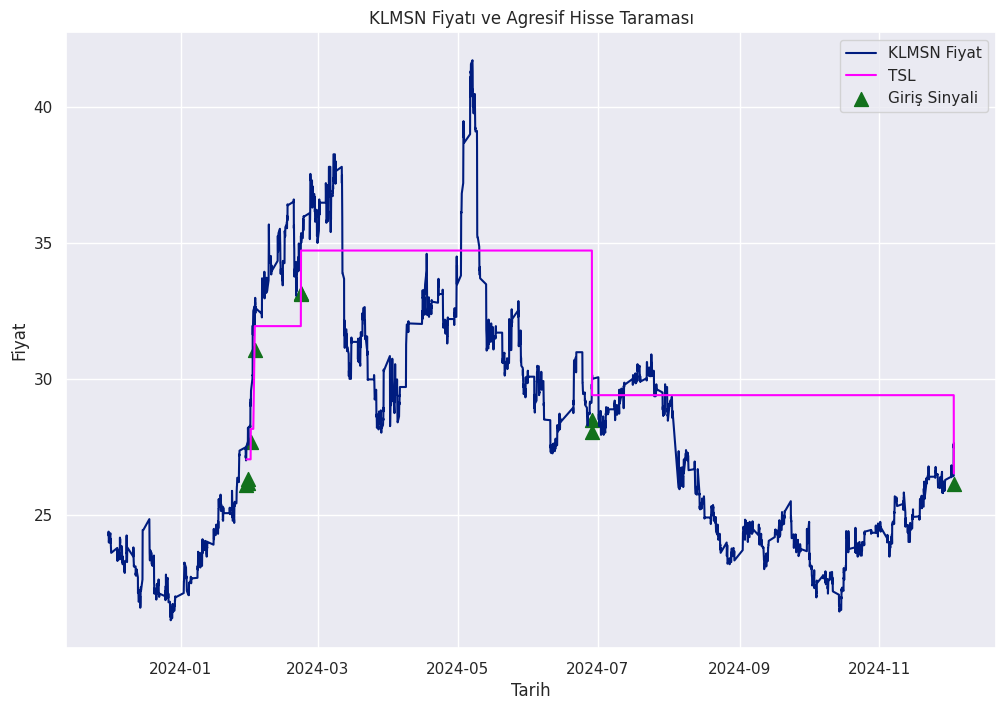

KLMSN için Bullish Engulfing Pattern Sinyal Tarihleri:
2024-01-29 18:00:00+03:00
2024-01-30 09:00:00+03:00
2024-01-30 10:00:00+03:00
2024-01-31 15:00:00+03:00
2024-02-02 09:00:00+03:00
2024-02-22 13:00:00+03:00
2024-02-22 15:00:00+03:00
2024-06-28 14:00:00+03:00
2024-06-28 15:00:00+03:00
2024-12-03 13:00:00+03:00


In [ ]:
# KÜTÜPHANELERİ YÜKLEME
import subprocess
subprocess.run(["pip", "install", "git+https://github.com/rongardF/tvdatafeed ", "--quiet"])
subprocess.run(["pip", "install", "tradingview-screener", "--quiet"])
subprocess.run(["pip", "install", "mplfinance", "--quiet"])
import logging
logging.getLogger('tvDatafeed.main').setLevel(logging.ERROR)
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tvDatafeed import TvDatafeed, Interval
import warnings
warnings.filterwarnings('ignore')

# HisseSeçimi
secilenHisseler = ["IHGZT", "AKYHO", "OBASE", "KLMSN"]
# İndikatör Parametreleri
length1 = 14
length = 20
length2 = 14
longMA = 50
shortMA = 20
interval = Interval.in_1_hour # Saatlik
# İndikatör içine gömülü parametreler
cmi = 0.15
oran = 0.90
katsayi = 1.05
stoporan = 1

# Money Flow Index (MFI)
def mfi(high, low, close, volume, window=14):
    typical_price = (high + low + close) / 3
    raw_money_flow = typical_price * volume
    positive_flow = []
    negative_flow = []

    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i - 1]:
            positive_flow.append(raw_money_flow[i])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i - 1]:
            positive_flow.append(0)
            negative_flow.append(raw_money_flow[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    positive_mf = np.sum(positive_flow[-window:])
    negative_mf = np.sum(negative_flow[-window:])
    mfi = 100 - (100 / (1 + positive_mf / negative_mf))
    return mfi

# Accumulation/Distribution (AD)
def calculate_ad(close, high, low, open, volume):
    ad_values = np.where((close == high) & (close == low) | (high == low), 0, (close - open) / (high - low) * volume)
    return ad_values

# Standard Moving Average (SMA)
def calculate_sma(data, window):
    sma = data.rolling(window=window).mean()
    return sma

# Secilen Hisseler İçin Ana Indikatorü Çağırma
for hisse in secilenHisseler:
  # Geçmiş Veri Çekme
  ticker = hisse
  exchange = "BIST"

  tv = TvDatafeed()
  data = tv.get_hist(symbol=ticker,exchange=exchange,interval=interval,n_bars=2500)
  data.rename(columns = {'open':'Open', 'high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace = True)
  data.index = data.index.tz_localize('UTC').tz_convert('Europe/Istanbul')

  # ANA FONKSİYON
  data['SMA50'] = calculate_sma(data['Close'], 50)
  data['SMA20'] = calculate_sma(data['Close'], 20)

  data['ad'] = calculate_ad(data['Close'], data['High'], data['Low'], data['Open'], data['Volume'])
  data['mf'] = data['ad'].rolling(window=length).sum()  / data['Volume'].rolling(window=length).sum()

  # Calculate topvolume for the last three bars
  data['barRatio'] = (data['Close'] - data['Open']) / (data['High'] - data['Low'])
  data['topVolume'] = data['Volume'].rolling(window=50).mean()

  data['topVolume1'] = data['topVolume'].shift(1)
  data['topVolume2'] = data['topVolume'].shift(2)
  data['topVolume3'] = data['topVolume'].shift(3)
  data['barRatio1'] = data['barRatio'].shift(1)
  data['barRatio2'] = data['barRatio'].shift(2)
  data['barRatio3'] = data['barRatio'].shift(3)

  # Bullish engulfing pattern tespit etme
  data['bullish_engulfing1'] = (
      (data['barRatio1'] > oran) & ((data['barRatio1'] * data['Volume'].shift(1)) > (data['topVolume1'].shift(1) * katsayi)) & (data['mf'].shift(1) > cmi) & (data['Close'] > data['High'].shift(1)) )
  data['bullish_engulfing2'] = (
      (data['barRatio2'] > oran) & ((data['barRatio2'] * data['Volume'].shift(2)) > (data['topVolume2'].shift(2) * katsayi)) & (data['mf'].shift(2) > cmi) & (data['Close'] > data['High'].shift(2)) )
  data['bullish_engulfing3'] = (
      (data['barRatio3'] > oran) & ((data['barRatio3'] * data['Volume'].shift(3)) > (data['topVolume3'].shift(3) * katsayi)) & (data['mf'].shift(3) > cmi) & (data['Close'] > data['High'].shift(3)) )

  bullish_engulfing_sinyal = data[data['bullish_engulfing1'] | data['bullish_engulfing2'] | data['bullish_engulfing3']]


  # TSL Çizgilerine karar verme
  K1 = np.nan
  K1_values = []
  for i in range(len(data)):
      if data['bullish_engulfing1'].iloc[i]:
          K1 = data['Low'].shift(1).iloc[i]
      elif data['bullish_engulfing2'].iloc[i]:
          K1 = data['Low'].shift(2).iloc[i]
      elif data['bullish_engulfing3'].iloc[i]:
          K1 = data['Low'].shift(3).iloc[i]
      K1_values.append(K1)
  data['K1'] = K1_values

  # GRAFİK ÇİZİMİ
  sns.set_theme(style='darkgrid', context='notebook', palette='dark')
  plt.figure(figsize=(12, 8))
  # Fiyat Çizgisi
  plt.plot(data['Close'], label=f'{ticker} Fiyat')

  # Ortalamaları Çiz
  # plt.plot(data['SMA50'], label='SMA50', color='red')
  # plt.plot(data['SMA20'], label='SMA20', color='green')

  # TSL Çizgisi
  plt.plot(data['K1'], color='magenta', label='TSL')

  # Bullish engulfing pattern işaretleyici
  bullish_dates = bullish_engulfing_sinyal.index
  plt.scatter(bullish_dates, data.loc[bullish_dates]['Low'] * 0.95, marker='^', color='g', s=100, label='Giriş Sinyali')

  # Adding title and labels
  plt.title(f'{ticker} Fiyatı ve Agresif Hisse Taraması')
  plt.xlabel('Tarih')
  plt.ylabel('Fiyat')
  plt.legend()
  plt.show()

  # Patternin tespit edildiği tarihleri listele
  print(f"{ticker} için Bullish Engulfing Pattern Sinyal Tarihleri:")
  for date in bullish_dates:
      print(date)
